# 06. FermatKDE y FermatKDClassifier

In [245]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, DensityMixin
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.neighbors import KernelDensity
from sklearn.datasets import (
    load_iris,
    load_digits,
    make_moons,
    fetch_openml,
    make_circles,
)
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path

from joblib import Memory


cachedir = "_cache"
memory = Memory(cachedir, verbose=0)


@memory.cache
def euclidean(X, Y=None):
    if Y is None:
        return squareform(pdist(X, metric="euclidean"))
    else:
        return cdist(X, Y, metric="euclidean")


@memory.cache
def sample_fermat(Q, alpha=1):
    return shortest_path(csr_matrix(euclidean(Q) ** alpha), directed=False)


class Bundle(dict):
    def __getattr__(self, key):
        try:
            return self[key]
        except KeyError:
            raise AttributeError(key)

    def __setattr__(self, key, value):
        self[key] = value

In [246]:
def iqr(X):
    return np.percentile(X, 75) - np.percentile(X, 25)


def pilot_h(dists):
    return 0.9 * np.minimum(dists.std(), iqr(dists) / 1.34) * len(dists) ** (-1 / 5)
    # return np.mean(sample_fermat(X, alpha=alpha))

In [247]:
isosceles = np.array([[0, 0], [3 / 2, np.sqrt(7 / 4)], [-3 / 2, np.sqrt(7 / 4)]])

In [248]:
euclidean(isosceles)

array([[0., 2., 2.],
       [2., 0., 3.],
       [2., 3., 0.]])

In [249]:
print(sample_fermat(isosceles, alpha=1), sample_fermat(isosceles, alpha=2), sep="\n")

[[0. 2. 2.]
 [2. 0. 3.]
 [2. 3. 0.]]
[[0. 4. 4.]
 [4. 0. 8.]
 [4. 8. 0.]]


In [250]:
class FermatKDE(BaseEstimator, DensityMixin):
    # MAX_DIST = 38.6
    MIN_LOG_SCORE = -1e6

    def __init__(self, alpha=1, bandwidth=1, d=None):
        self.bandwidth = bandwidth
        self.alpha = alpha
        self.d = d  # TODO: Evitar completamente? Quitando el h^-d del score?

    def fit(self, X):
        self.Q_ = X
        # A is the adjacency matrix with Fermat distances as edge weights
        self.A_ = sample_fermat(X, self.alpha)
        if self.d is None:
            self.d = self.D
        return self

    @property
    def N(self):
        return self.Q_.shape[0]

    @property
    def D(self):
        return self.Q_.shape[1]

    def _sample_distances(self, X):
        to_Q = euclidean(X, self.Q_) ** self.alpha
        sample_distances = np.zeros((X.shape[0], self.N))
        for i in range(len(X)):
            sample_distances[i, :] = np.min(to_Q[i].T + self.A_, axis=1)
        return sample_distances

    def score_samples(self, X=None, log=True):
        if X is None:
            X = self.Q_

        score = np.exp(-0.5 * (self._sample_distances(X) / self.bandwidth) ** 2).sum(1)

        if log:
            return (
                -np.log(self.N)
                - self.d * np.log(self.bandwidth)
                - self.d / 2 * np.log(2 * np.pi)
                + np.maximum(np.log(score), self.MIN_LOG_SCORE)
            )

        else:
            return (
                self.N**-1
                * (self.bandwidth**-self.d)
                * (2 * np.pi) ** (-self.d / 2)
                * score
            )

    def score(self, X=None):
        if X is None:
            X = self.Q_
        return self.score_samples(X).sum()

In [251]:
from fermat import Fermat


class OOSFermatKDE:
    def __init__(self, alpha=1, bandwidth=1):
        self.alpha = alpha
        self.bandwidth = bandwidth

    def fit(self, X):
        self.X_ = X
        self.euclidean_dists_ = euclidean(X)
        self.fermat_ = Fermat(alpha=self.alpha, path_method="FW").fit(
            self.euclidean_dists_
        )
        self.fermat_dists_ = self.fermat_.get_distances()
        self.n_, self.dim_ = X.shape
        return self

    def _dist_to_edge(self, X_from):
        return np.array(
            [
                [((x_from - x_to) ** 2).sum() ** (self.alpha / 2) for x_to in self.X_]
                for x_from in X_from
            ]
        )

    def _distances(self, X_from):
        to_edge = self._dist_to_edge(X_from)
        dists = np.zeros((X_from.shape[0], self.n_))
        for i, x_from in enumerate(X_from):
            dists[i, :] = np.min(to_edge[i].T + self.fermat_dists_, axis=1)
        return dists

    def density(self, X, log=True):
        densities = (
            (self.bandwidth**-self.dim_)
            * (2 * np.pi) ** (-self.dim_ / 2)
            * np.exp(-1 / 2 * (self._distances(X) / self.bandwidth) ** 2).mean(axis=1)
        )
        return np.log(densities) if log else densities

In [364]:
# X, y = make_circles(n_samples=1000, noise=0.05, random_state=42)
# X, y = make_moons(n_samples=2000, noise=0.1)
# X, y = load_digits(return_X_y=True)
# X, y = load_iris(return_X_y=True)
X, y = fetch_openml(
    "mnist_784", version=1, parser="auto", return_X_y=True, as_frame=False
)

In [253]:
X.shape, np.unique(y)

((1797, 64), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [254]:
y = y.astype(int)
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [255]:
pd.Series(y).value_counts()

3    183
1    182
5    182
4    181
6    181
9    180
7    179
0    178
2    177
8    174
dtype: int64

In [256]:
X0 = X[y == 0]  # [:1000]
X1 = X[y == 1]
# X2 = X[y == 2][:500]
# X0 = X[y == 0][1000:1100,]
X.shape

(1797, 64)

In [257]:
# pixels = X[0].reshape(28, 28)
# print(pixels[15:20, 15:20])
# plt.imshow(pixels, cmap="gray")

In [258]:
seed = 2018
# Choosing train/test split by indices is equivalent to choosing rows themselves
idx_train, idx_test = train_test_split(
    np.arange(len(X0)), test_size=0.2, random_state=seed
)
tt_cv = [(idx_train, idx_test)]
ss_cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=seed)

In [259]:
alpha = 1
A = sample_fermat(X0[idx_train], alpha)

In [260]:
pilot_h(A)

2.2059434532807267

In [261]:
grid = {"bandwidth": pilot_h(A) * np.logspace(-3, 3, 61)}

In [262]:
fkde = GridSearchCV(FermatKDE(alpha=alpha), grid, cv=ss_cv, n_jobs=-1, verbose=1).fit(
    X0
)
fdf = pd.DataFrame(fkde.cv_results_)

Fitting 20 folds for each of 61 candidates, totalling 1220 fits


/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40327/1327241305.py:44: RuntimeWarning: divide by zero encountered in log
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40327/1327241305.py:44: RuntimeWarning: divide by zero encountered in log
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40327/1327241305.py:44: RuntimeWarning: divide by zero encountered in log
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40327/1327241305.py:44: RuntimeWarning: divide by zero encountered in log
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40327/1327241305.py:44: RuntimeWarning: divide by zero encountered in log
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40327/1327241305.py:44: RuntimeWarning: divide by zero encountered in log
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40327/1327241305.py:44: RuntimeWarning: divide by zero encountered in log
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40327/1327

In [263]:
cv_scores = fdf.melt(
    id_vars="param_bandwidth",
    value_vars=[c for c in fdf.columns if "split" in c],
    var_name="split",
    value_name="score",
)
cv_scores["param_bandwidth"] = cv_scores.param_bandwidth.astype(float)
cv_scores = cv_scores.groupby("param_bandwidth").score.agg([np.mean, np.std, len])
cv_scores

,mean,std,len
param_bandwidth,,,
0.002206,-3.598820e+07,0.000000,20
0.002777,-3.598873e+07,0.000000,20
0.003496,-3.598926e+07,0.000000,20
0.004401,-3.598979e+07,0.000000,20
0.005541,-3.599033e+07,0.000000,20
...,...,...,...
878.201907,-1.773348e+04,0.000514,20
1105.590697,-1.826399e+04,0.000325,20
1391.856223,-1.879450e+04,0.000205,20


In [264]:
best_index = cv_scores["mean"].argmax()
N_SD = 3
mu, sd = cv_scores.iloc[best_index][["mean", "std"]]
mu, sd, mu - N_SD * sd

(-4941.573926748273, 61.70596363975899, -5126.69181766755)

In [265]:
h_NSD = cv_scores[cv_scores["mean"] > mu - N_SD * sd].index.max()
h_CV = cv_scores.index[best_index]

In [266]:
h_NSD, h_CV

(2.2059434532807267, 1.7522431691460667)

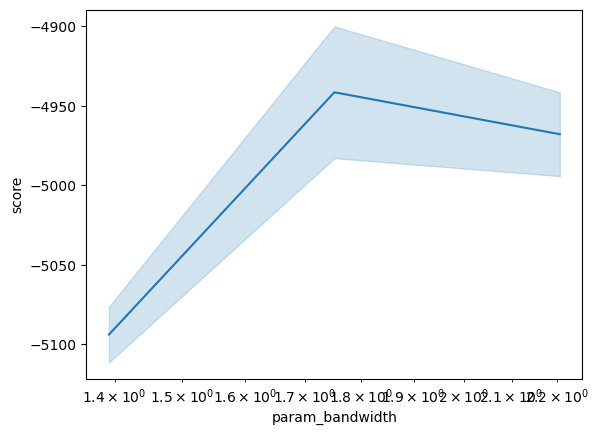

In [267]:
data = fdf.melt(
    id_vars="param_bandwidth",
    value_vars=[c for c in fdf.columns if "split" in c],
    var_name="split",
    value_name="score",
)
sns.lineplot(
    x="param_bandwidth",
    y="score",
    errorbar=("se", 3),
    data=data[data.score.between(mu - 3 * sd, mu + 3 * sd)],
)
plt.xscale("log")

In [268]:
fdf

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bandwidth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002930,0.001774,0.004598,0.001878,0.002206,{'bandwidth': 0.002205943453280727},-3.598820e+07,-3.598820e+07,-3.598820e+07,-3.598820e+07,...,-3.598820e+07,-3.598820e+07,-3.598820e+07,-3.598820e+07,-3.598820e+07,-3.598820e+07,-3.598820e+07,-3.598820e+07,0.000000e+00,41
1,0.001361,0.000604,0.003228,0.001837,0.002777,{'bandwidth': 0.0027771182703160866},-3.598873e+07,-3.598873e+07,-3.598873e+07,-3.598873e+07,...,-3.598873e+07,-3.598873e+07,-3.598873e+07,-3.598873e+07,-3.598873e+07,-3.598873e+07,-3.598873e+07,-3.598873e+07,7.450581e-09,42
2,0.001140,0.000290,0.002585,0.000638,0.003496,{'bandwidth': 0.0034961847620587853},-3.598926e+07,-3.598926e+07,-3.598926e+07,-3.598926e+07,...,-3.598926e+07,-3.598926e+07,-3.598926e+07,-3.598926e+07,-3.598926e+07,-3.598926e+07,-3.598926e+07,-3.598926e+07,1.490116e-08,43
3,0.001048,0.000252,0.002356,0.000957,0.004401,{'bandwidth': 0.0044014358412833455},-3.598979e+07,-3.598979e+07,-3.598979e+07,-3.598979e+07,...,-3.598979e+07,-3.598979e+07,-3.598979e+07,-3.598979e+07,-3.598979e+07,-3.598979e+07,-3.598979e+07,-3.598979e+07,7.450581e-09,44
4,0.001014,0.000440,0.002278,0.000689,0.005541,{'bandwidth': 0.005541079428973243},-3.599033e+07,-3.599033e+07,-3.599033e+07,-3.599033e+07,...,-3.599033e+07,-3.599033e+07,-3.599033e+07,-3.599033e+07,-3.599033e+07,-3.599033e+07,-3.599033e+07,-3.599033e+07,0.000000e+00,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.001607,0.002037,0.003431,0.004223,878.201907,{'bandwidth': 878.201906586602},-1.773348e+04,-1.773348e+04,-1.773348e+04,-1.773348e+04,...,-1.773348e+04,-1.773348e+04,-1.773348e+04,-1.773348e+04,-1.773348e+04,-1.773348e+04,-1.773348e+04,-1.773348e+04,5.014539e-04,32
57,0.001368,0.001668,0.003726,0.003685,1105.590697,{'bandwidth': 1105.5906968879597},-1.826399e+04,-1.826399e+04,-1.826399e+04,-1.826399e+04,...,-1.826399e+04,-1.826399e+04,-1.826399e+04,-1.826399e+04,-1.826399e+04,-1.826399e+04,-1.826399e+04,-1.826399e+04,3.163970e-04,33
58,0.001313,0.002294,0.005357,0.007657,1391.856223,{'bandwidth': 1391.8562233554767},-1.879450e+04,-1.879450e+04,-1.879450e+04,-1.879450e+04,...,-1.879450e+04,-1.879450e+04,-1.879450e+04,-1.879450e+04,-1.879450e+04,-1.879450e+04,-1.879450e+04,-1.879450e+04,1.996334e-04,34
59,0.000894,0.000523,0.002970,0.003862,1752.243169,{'bandwidth': 1752.2431691460667},-1.932501e+04,-1.932501e+04,-1.932501e+04,-1.932501e+04,...,-1.932501e+04,-1.932501e+04,-1.932501e+04,-1.932501e+04,-1.932501e+04,-1.932501e+04,-1.932501e+04,-1.932501e+04,1.259603e-04,35


In [269]:
skde = GridSearchCV(KernelDensity(), grid, cv=ss_cv, n_jobs=-1, verbose=1).fit(X0)
sdf = pd.DataFrame(skde.cv_results_)

Fitting 20 folds for each of 61 candidates, totalling 1220 fits


In [270]:
fkde.best_params_, fkde.best_score_, skde.best_params_, skde.best_score_

({'bandwidth': 1.7522431691460667},
 -4941.573926748273,
 {'bandwidth': 1.3918562233554752},
 -4760.048687131491)

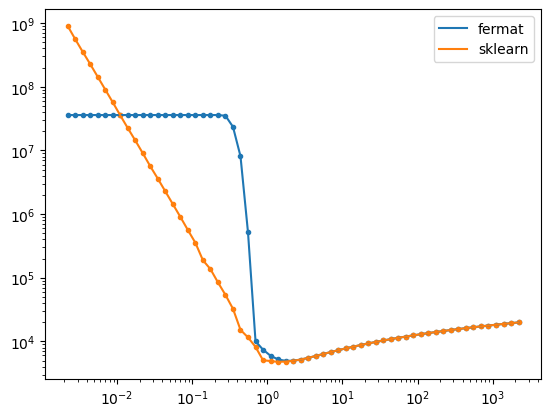

In [271]:
import seaborn as sns

for method, df in {"fermat": fdf, "sklearn": sdf}.items():
    plt.plot(df.param_bandwidth, -df.mean_test_score, label=method)
    plt.scatter(df.param_bandwidth, -df.mean_test_score, marker=".")
    # sns.lineplot(x="param_bandwidth", y="mean_test_score", label=method, data=df)#[df["param_bandwidth"].between(5, 100)])
    # sns.scatterplot(x="param_bandwidth", y="mean_test_score", label="fermat", data=df)#fdf[fdf["param_bandwidth"].between(0.3, 3)])
plt.xscale("log")
plt.yscale("log")
plt.legend()
# plt.xlim(0.4, 10)
plt.show()

In [272]:
fkde.best_params_, fkde.best_score_, skde.best_params_, skde.best_score_

({'bandwidth': 1.7522431691460667},
 -4941.573926748273,
 {'bandwidth': 1.3918562233554752},
 -4760.048687131491)

In [273]:
# retrain fkde and skde with the best parameters from the grid search
fkde = FermatKDE(alpha=alpha, bandwidth=fkde.best_params_["bandwidth"]).fit(
    X0[idx_train]
)
skde = KernelDensity(bandwidth=skde.best_params_["bandwidth"]).fit(X0[idx_train])

In [274]:
fkde.score_samples(X0[idx_train]).mean(), fkde.score_samples(
    X0[idx_test]
).mean(), fkde.score_samples(X1).mean()

(-99.66528697803717, -137.34350454020404, -429.55433066499967)

In [275]:
skde.score_samples(X0[idx_train]).mean(), skde.score_samples(
    X0[idx_test]
).mean(), skde.score_samples(X1).mean()

(-84.92874238323351, -132.85182219252079, -571.5543364023915)

In [276]:
pd.Series(fkde.score_samples(X0[idx_test])).describe()

count     36.000000
mean    -137.343505
std       16.217144
min     -177.831044
25%     -141.719249
50%     -132.563495
75%     -126.804996
max     -113.670128
dtype: float64

In [277]:
pd.Series(skde.score_samples(X0[idx_test])).describe()

count     36.000000
mean    -132.851822
std       25.660552
min     -208.814797
25%     -135.333265
50%     -120.334581
75%     -117.423141
max     -107.124924
dtype: float64

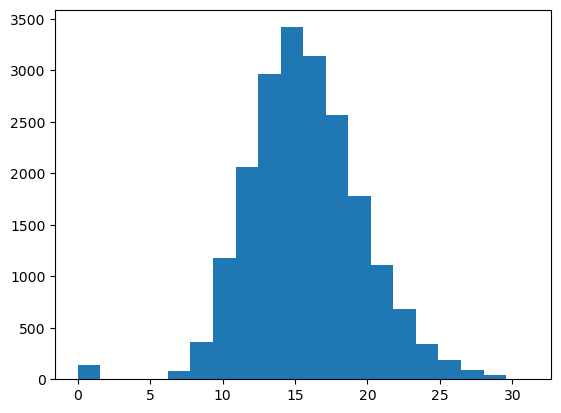

In [278]:
plt.hist((fkde.A_ / fkde.bandwidth).flatten(), bins=20)
plt.show()

In [279]:
# pd.options.display.float_format = "{:.2e}".format
with pd.option_context("display.float_format", "{:.2e}".format):
    print(sdf[["param_bandwidth", "mean_test_score"]].head())

  param_bandwidth  mean_test_score
0        2.21e-03        -9.06e+08
1        2.78e-03        -5.62e+08
2        3.50e-03        -3.55e+08
3        4.40e-03        -2.28e+08
4        5.54e-03        -1.44e+08


In [280]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numbers

In [281]:
ss_cv = ShuffleSplit(n_splits=10, test_size=0.5, random_state=1942)

In [282]:
class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE"""

    def __init__(self, bandwidth=-1.0):
        self.bandwidth = bandwidth

    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.bandwidths_ = self.bandwidth
        if isinstance(self.bandwidths_, numbers.Number):
            self.bandwidths_ = np.repeat(self.bandwidth, len(self.classes_))
        self.bandwidths_ = np.array(self.bandwidths_, dtype=float)
        for i, bw in enumerate(self.bandwidths_):
            Xi = training_sets[i]
            if bw == -1:  # automatic bandwidth selection
                pilot = np.mean(euclidean(Xi))
                grid = {"bandwidth": pilot * np.logspace(-4, 4, 41)}
                print(grid)
                print(f"GSCV on {pilot} * np.logspace(-4, 4, 41) for {i}th class")
                search = GridSearchCV(KernelDensity(kernel="gaussian"), grid, cv=ss_cv)
                search.fit(Xi)
                print(search.best_params_)
                self.bandwidths_[i] = search.best_params_["bandwidth"]
                print(search.best_params_["bandwidth"], self.bandwidths_.round(3))

        self.models_ = [
            KernelDensity(bandwidth=hi, kernel="gaussian").fit(Xi)
            for hi, Xi in zip(self.bandwidths_, training_sets)
        ]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0]) for Xi in training_sets]
        return self

    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X) for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

In [283]:
from sklearn.base import BaseEstimator, ClassifierMixin


class JakeKDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE

    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """

    def __init__(self, bandwidth=1.0, kernel="gaussian"):
        self.bandwidth = bandwidth
        self.kernel = kernel

    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [
            KernelDensity(bandwidth=self.bandwidth, kernel=self.kernel).fit(Xi)
            for Xi in training_sets
        ]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0]) for Xi in training_sets]
        return self

    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X) for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

In [284]:
euclid = [euclidean(X[y == i]) for i in np.unique(y)]

In [285]:
idx_train, idx_test = train_test_split(
    np.arange(len(X)), test_size=0.5, random_state=seed
)

clf = KDEClassifier(bandwidth=-1).fit(X[idx_train], y[idx_train])

{'bandwidth': array([2.76054099e-03, 4.37516261e-03, 6.93416544e-03, 1.09899116e-02,
       1.74178361e-02, 2.76054099e-02, 4.37516261e-02, 6.93416544e-02,
       1.09899116e-01, 1.74178361e-01, 2.76054099e-01, 4.37516261e-01,
       6.93416544e-01, 1.09899116e+00, 1.74178361e+00, 2.76054099e+00,
       4.37516261e+00, 6.93416544e+00, 1.09899116e+01, 1.74178361e+01,
       2.76054099e+01, 4.37516261e+01, 6.93416544e+01, 1.09899116e+02,
       1.74178361e+02, 2.76054099e+02, 4.37516261e+02, 6.93416544e+02,
       1.09899116e+03, 1.74178361e+03, 2.76054099e+03, 4.37516261e+03,
       6.93416544e+03, 1.09899116e+04, 1.74178361e+04, 2.76054099e+04,
       4.37516261e+04, 6.93416544e+04, 1.09899116e+05, 1.74178361e+05,
       2.76054099e+05])}
GSCV on 27.605409851175544 * np.logspace(-4, 4, 41) for 0th class
{'bandwidth': 1.7417836092985097}
1.7417836092985097 [ 1.742 -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.   ]
{'bandwidth': array([4.07892813e-03, 6.46466542e-03, 1.02458

In [286]:
clf.bandwidths_

array([1.74178361, 2.57362966, 2.37854673, 2.19772507, 2.36497211,
       2.35934091, 1.96890032, 2.29677579, 2.39279749, 2.37215514])

In [287]:
pd.Series(clf.predict(X[idx_train])).value_counts()

8    99
0    96
5    95
7    91
4    91
1    89
2    87
3    85
9    84
6    81
dtype: int64

In [288]:
# measure clf accuracy on train and test datasets
clf.score(X[idx_train], y[idx_train]), clf.score(X[idx_test], y[idx_test])

(1.0, 0.7897664071190211)

In [289]:
clf2 = GridSearchCV(KDEClassifier(), {"bandwidth": np.logspace(-4, 4, 81)}, cv=10).fit(
    X[idx_train], y[idx_train]
)

/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40327/260138213.py:37: RuntimeWarning: invalid value encountered in divide
  return result / result.sum(1, keepdims=True)
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40327/260138213.py:37: RuntimeWarning: invalid value encountered in divide
  return result / result.sum(1, keepdims=True)
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40327/260138213.py:37: RuntimeWarning: invalid value encountered in divide
  return result / result.sum(1, keepdims=True)
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40327/260138213.py:37: RuntimeWarning: invalid value encountered in divide
  return result / result.sum(1, keepdims=True)
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40327/260138213.py:37: RuntimeWarning: invalid value encountered in divide
  return result / result.sum(1, keepdims=True)
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40327/260138213.py:37: RuntimeWarnin

In [290]:
clf2.best_params_, clf2.best_score_

({'bandwidth': 3.9810717055349776}, 0.9899750312109864)

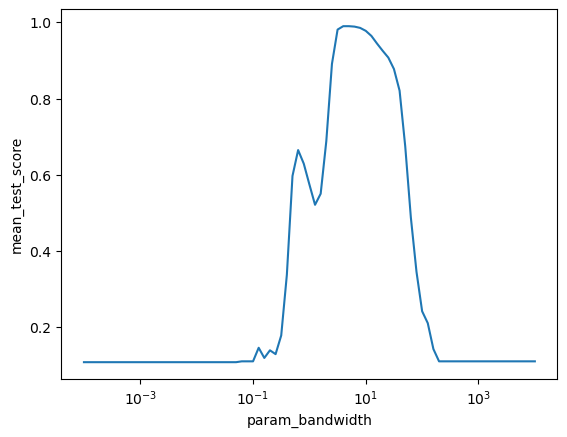

In [291]:
sns.lineplot(
    x="param_bandwidth", y="mean_test_score", data=pd.DataFrame(clf2.cv_results_)
)
plt.xscale("log")

In [292]:
clf.bandwidths_, clf2.best_params_

(array([1.74178361, 2.57362966, 2.37854673, 2.19772507, 2.36497211,
        2.35934091, 1.96890032, 2.29677579, 2.39279749, 2.37215514]),
 {'bandwidth': 3.9810717055349776})

In [293]:
df = pd.DataFrame(clf2.cv_results_)
df[df.param_bandwidth.between(0.1, 10)][["param_bandwidth", "mean_test_score"]]

,param_bandwidth,mean_test_score
30,0.1,0.110250
31,0.125893,0.145855
32,0.158489,0.119151
33,0.199526,0.139164
34,0.251189,0.129164
35,0.316228,0.178190
36,0.398107,0.337428
37,0.501187,0.596891
38,0.630957,0.664757
39,0.794328,0.629101


In [294]:
pd.crosstab(clf.predict(X[idx_test]), y[idx_test])

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,74,0,0,0,0,3,0,0,2,12
1,0,79,1,0,0,0,0,0,0,0
2,1,1,76,9,0,2,0,0,2,3
3,1,2,8,75,1,11,0,7,15,14
4,1,3,0,0,87,1,0,1,4,3
5,0,1,0,2,0,59,2,0,1,2
6,2,1,1,2,0,0,96,0,3,1
7,0,1,0,1,1,3,0,71,5,1
8,1,4,2,5,0,6,1,3,38,5


In [295]:
disc = clf.predict(X[idx_test]) != y[idx_test]
if np.any(disc):
    for i in zip(y[idx_test][disc], clf.predict_proba(X[idx_test][disc]).round(2)[:20]):
        print(i)

(8, array([0.  , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.  , 0.01, 0.  ]))
(8, array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
(5, array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]))
(8, array([0.  , 0.04, 0.06, 0.07, 0.  , 0.  , 0.  , 0.8 , 0.02, 0.  ]))
(8, array([0.  , 0.  , 0.  , 0.94, 0.  , 0.  , 0.  , 0.05, 0.  , 0.  ]))
(3, array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]))
(8, array([0.  , 0.  , 0.  , 0.98, 0.  , 0.  , 0.  , 0.  , 0.02, 0.  ]))
(8, array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]))
(8, array([0.  , 0.  , 0.  , 0.31, 0.  , 0.06, 0.63, 0.  , 0.  , 0.  ]))
(8, array([0.  , 0.  , 0.  , 0.72, 0.  , 0.  , 0.  , 0.22, 0.  , 0.05]))
(3, array([0.  , 0.  , 0.99, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]))
(9, array([0.  , 0.  , 0.  , 0.29, 0.  , 0.  , 0.71, 0.  , 0.  , 0.  ]))
(9, array([0.  , 0.  , 0.51, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.49]))
(7, array([0.  , 0.  , 0.  , 0.31, 0.  , 0.  , 0.  , 0.  , 0.08, 0.61]))
(4, array([0.  , 0.17, 0.  , 0.83, 0.  , 0.  , 0.  , 0.  ,

In [296]:
pd.Series(clf2.predict(X[idx_train])).value_counts()

8    99
0    96
5    95
7    91
4    91
1    89
2    87
3    85
9    84
6    81
dtype: int64

In [297]:
pd.crosstab(clf2.predict(X[idx_test]), y[idx_test])

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,82,0,0,0,0,0,0,0,0,0
1,0,93,0,0,0,0,1,0,0,0
2,0,0,89,0,0,0,0,0,0,0
3,0,0,1,94,0,0,0,0,0,2
4,0,0,0,0,90,0,0,0,0,0
5,0,0,0,3,0,84,0,1,0,0
6,0,0,0,0,0,1,99,0,0,0
7,0,0,0,0,0,0,0,86,0,0
8,0,0,0,1,0,0,0,0,75,1


In [298]:
disc = clf2.predict(X[idx_test]) != y[idx_test]
if np.any(disc):
    for i in zip(
        y[idx_test][disc], clf2.predict_proba(X[idx_test][disc]).round(2)[:20]
    ):
        print(i)

(5, array([0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.96, 0.  , 0.  , 0.  ]))
(5, array([0.  , 0.  , 0.  , 0.14, 0.  , 0.  , 0.  , 0.  , 0.  , 0.86]))
(9, array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.99, 0.  ]))
(9, array([0.  , 0.  , 0.  , 0.96, 0.  , 0.02, 0.  , 0.  , 0.  , 0.01]))
(3, array([0.  , 0.  , 0.  , 0.03, 0.  , 0.71, 0.  , 0.  , 0.  , 0.26]))
(2, array([0.  , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ]))
(7, array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.19, 0.  , 0.81]))
(3, array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]))
(9, array([0.  , 0.  , 0.  , 0.63, 0.  , 0.  , 0.  , 0.  , 0.  , 0.37]))
(3, array([0.  , 0.  , 0.  , 0.04, 0.  , 0.95, 0.  , 0.  , 0.01, 0.  ]))
(6, array([0.  , 0.92, 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.  , 0.  ]))
(7, array([0.  , 0.  , 0.  , 0.04, 0.  , 0.87, 0.  , 0.01, 0.  , 0.08]))
(5, array([0.  , 0.  , 0.  , 0.  , 0.  , 0.26, 0.  , 0.  , 0.  , 0.74]))
(3, array([0. , 0. , 0. , 0.4, 0. , 0. , 0. , 0. , 0.6, 0. ]))


In [299]:
# measure clf2 accuracy on train and test datasets
clf2.score(X[idx_train], y[idx_train]), clf2.score(X[idx_test], y[idx_test])

(1.0, 0.9844271412680756)

In [300]:
pd.crosstab(y[idx_train], clf.predict(X[idx_train]))

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,96,0,0,0,0,0,0,0,0,0
1,0,89,0,0,0,0,0,0,0,0
2,0,0,87,0,0,0,0,0,0,0
3,0,0,0,85,0,0,0,0,0,0
4,0,0,0,0,91,0,0,0,0,0
5,0,0,0,0,0,95,0,0,0,0
6,0,0,0,0,0,0,81,0,0,0
7,0,0,0,0,0,0,0,91,0,0
8,0,0,0,0,0,0,0,0,99,0


In [301]:
pd.crosstab(y[idx_test], clf.predict(X[idx_test]))

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,74,0,1,1,1,0,2,0,1,2
1,0,79,1,2,3,1,1,1,4,1
2,0,1,76,8,0,0,1,0,2,2
3,0,0,9,75,0,2,2,1,5,4
4,0,0,0,1,87,0,0,1,0,1
5,3,0,2,11,1,59,0,3,6,2
6,0,0,0,0,0,2,96,0,1,1
7,0,0,0,7,1,0,0,71,3,6
8,2,0,2,15,4,1,3,5,38,5


In [302]:
from sklearn.model_selection import cross_val_score

cross_val_score(clf, X, y, cv=10)

{'bandwidth': array([2.73458614e-03, 4.33402695e-03, 6.86896981e-03, 1.08865835e-02,
       1.72540721e-02, 2.73458614e-02, 4.33402695e-02, 6.86896981e-02,
       1.08865835e-01, 1.72540721e-01, 2.73458614e-01, 4.33402695e-01,
       6.86896981e-01, 1.08865835e+00, 1.72540721e+00, 2.73458614e+00,
       4.33402695e+00, 6.86896981e+00, 1.08865835e+01, 1.72540721e+01,
       2.73458614e+01, 4.33402695e+01, 6.86896981e+01, 1.08865835e+02,
       1.72540721e+02, 2.73458614e+02, 4.33402695e+02, 6.86896981e+02,
       1.08865835e+03, 1.72540721e+03, 2.73458614e+03, 4.33402695e+03,
       6.86896981e+03, 1.08865835e+04, 1.72540721e+04, 2.73458614e+04,
       4.33402695e+04, 6.86896981e+04, 1.08865835e+05, 1.72540721e+05,
       2.73458614e+05])}
GSCV on 27.345861354571735 * np.logspace(-4, 4, 41) for 0th class
{'bandwidth': 1.725407206280413}
1.725407206280413 [ 1.725 -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.   ]
{'bandwidth': array([4.10698401e-03, 6.50913100e-03, 1.0316277

array([0.51666667, 0.63333333, 0.53333333, 0.56111111, 0.63333333,
       0.56666667, 0.48888889, 0.68715084, 0.58659218, 0.49162011])

In [306]:
euclid = [euclidean(X[y == i]) for i in np.unique(y)]

In [318]:
np.arange(11)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [329]:
from time import time
sample_fmt = Bundle()
alphas = np.linspace(1, 2, 11).round(1)

In [331]:
for i in np.unique(y):
    for alpha in alphas:
        alpha = round(alpha, 1)
        t0 = time()
        sample_fmt[(i, alpha)]= sample_fermat(X[y == i], alpha) 
        # print(i, alpha, round(time() - t0, 3))

In [332]:
pilots = {k: pilot_h(v) for k, v in sample_fmt.items()}

In [334]:
np.logspace(1, 3, 11)

array([  10.        ,   15.84893192,   25.11886432,   39.81071706,
         63.09573445,  100.        ,  158.48931925,  251.18864315,
        398.10717055,  630.95734448, 1000.        ])

In [336]:
X.shape

(1797, 64)

In [365]:
def sample_rows(X, K):
    N = X.shape[0]
    return X[np.random.choice(N, min(K, N), replace=False), :]

_X = sample_rows(X, 1000)
samples = {alpha: sample_fermat(_X, alpha) for alpha in alphas}

In [366]:
grid = [Bundle(alpha=[alpha], bandwidth=pilot_h(samples[alpha]) * np.logspace(-3, 3, 31)) for alpha in alphas]

In [367]:
grid

[{'alpha': [1.0],
  'bandwidth': array([8.01732179e-02, 1.27065987e-01, 2.01386018e-01, 3.19175329e-01,
         5.05858806e-01, 8.01732179e-01, 1.27065987e+00, 2.01386018e+00,
         3.19175329e+00, 5.05858806e+00, 8.01732179e+00, 1.27065987e+01,
         2.01386018e+01, 3.19175329e+01, 5.05858806e+01, 8.01732179e+01,
         1.27065987e+02, 2.01386018e+02, 3.19175329e+02, 5.05858806e+02,
         8.01732179e+02, 1.27065987e+03, 2.01386018e+03, 3.19175329e+03,
         5.05858806e+03, 8.01732179e+03, 1.27065987e+04, 2.01386018e+04,
         3.19175329e+04, 5.05858806e+04, 8.01732179e+04])},
 {'alpha': [1.1],
  'bandwidth': array([1.93736494e-01, 3.07051650e-01, 4.86644070e-01, 7.71278873e-01,
         1.22239464e+00, 1.93736494e+00, 3.07051650e+00, 4.86644070e+00,
         7.71278873e+00, 1.22239464e+01, 1.93736494e+01, 3.07051650e+01,
         4.86644070e+01, 7.71278873e+01, 1.22239464e+02, 1.93736494e+02,
         3.07051650e+02, 4.86644070e+02, 7.71278873e+02, 1.22239464e+03,
  

In [368]:
class FermatKDEClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, bandwidth=-1.0, alpha=1.0, method="fermat"):
        self.bandwidth = bandwidth
        self.alpha = alpha
        self.method = method

    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.bandwidths_ = self.bandwidth
        if isinstance(self.bandwidths_, numbers.Number):
            self.bandwidths_ = np.repeat(self.bandwidth, len(self.classes_))
        self.bandwidths_ = np.array(self.bandwidths_, dtype=float)
        for i, bw in enumerate(self.bandwidths_):
            Xi = training_sets[i]
            if bw == -1:  # automatic bandwidth selection
                pilot = np.mean(euclidean(Xi))
                grid = {"bandwidth": pilot * np.logspace(-4, 4, 41)}
                print(grid)
                print(f"GSCV on {pilot} * np.logspace(-4, 4, 41) for {i}th class")
                search = GridSearchCV(KernelDensity(kernel="gaussian"), grid, cv=ss_cv)
                search.fit(Xi)
                print(search.best_params_)
                self.bandwidths_[i] = search.best_params_["bandwidth"]
                print(search.best_params_["bandwidth"], self.bandwidths_.round(3))

        self.models_ = [
            FermatKDE(bandwidth=hi, alpha=self.alpha).fit(Xi)
            for hi, Xi in zip(self.bandwidths_, training_sets)
        ]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0]) for Xi in training_sets]
        return self

    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X) for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

In [369]:
pd.Series(y).value_counts()

1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
dtype: int64

In [370]:
idx_train, idx_test = train_test_split(
    np.arange(len(X)), test_size=0.8, random_state=seed
)

In [373]:
fclf = FermatKDEClassifier(alpha=1.5, bandwidth=10).fit(X[idx_train], y[idx_train])

In [374]:
X.shape, idx_train.shape, idx_test.shape

((70000, 784), (14000,), (56000,))

In [376]:
fclf.score(X[idx_train][:1000], y[idx_train][:1000]), fclf.score(X[idx_test][:1000], y[idx_test][:1000])

/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40327/1327241305.py:44: RuntimeWarning: divide by zero encountered in log
  + np.maximum(np.log(score), self.MIN_LOG_SCORE)
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40327/2758414551.py:38: RuntimeWarning: invalid value encountered in divide
  return result / result.sum(1, keepdims=True)
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40327/1327241305.py:44: RuntimeWarning: divide by zero encountered in log
  + np.maximum(np.log(score), self.MIN_LOG_SCORE)
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40327/2758414551.py:38: RuntimeWarning: invalid value encountered in divide
  return result / result.sum(1, keepdims=True)


(0.085, 0.089)

In [372]:
mnist_fclf_search = GridSearchCV(
    FermatKDEClassifier(),
    Bundle(alpha=[1, 2], bandwidth=[0.1, 1, 10]),
    cv=5,
    n_jobs=-1,
    verbose=1,
).fit(X[idx_train], y[idx_train])

Fitting 5 folds for each of 6 candidates, totalling 30 fits


KeyboardInterrupt: 

In [ ]:
fclf_search.best_params_, fclf_search.best_score_

({'alpha': 1.0, 'bandwidth': 1.0803059564933777}, 0.9910861423220976)

In [ ]:
df = pd.DataFrame(fclf_search.cv_results_)

In [ ]:
df = pd.DataFrame(mnist_fclf_search.cv_results_)

In [ ]:
df["OOS_score"] = df.apply(
    lambda x: FermatKDEClassifier(**x.params)
    .fit(X[idx_train], y[idx_train])
    .score(X[idx_test], y[idx_test]),
    axis=1,
)

/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40327/1327241305.py:44: RuntimeWarning: divide by zero encountered in log
  + np.maximum(np.log(score), self.MIN_LOG_SCORE)
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40327/2758414551.py:38: RuntimeWarning: invalid value encountered in divide
  return result / result.sum(1, keepdims=True)
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40327/1327241305.py:44: RuntimeWarning: divide by zero encountered in log
  + np.maximum(np.log(score), self.MIN_LOG_SCORE)
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40327/2758414551.py:38: RuntimeWarning: invalid value encountered in divide
  return result / result.sum(1, keepdims=True)
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40327/1327241305.py:44: RuntimeWarning: divide by zero encountered in log
  + np.maximum(np.log(score), self.MIN_LOG_SCORE)
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40327/2758414551.py:38: Runt

In [362]:
len(idx_train), len(idx_test)

(898, 899)

In [363]:
899 * 0.989989

890.0001110000001

In [361]:
df[["param_alpha", "param_bandwidth", "mean_test_score", "OOS_score"]].sort_values("OOS_score", ascending=False).head(20)

,param_alpha,param_bandwidth,mean_test_score,OOS_score
142,1.4,45.23989,0.977728,0.989989
265,1.8,160.870414,0.985518,0.988877
111,1.3,28.464967,0.981061,0.988877
296,1.9,238.066501,0.984407,0.988877
234,1.7,107.1922,0.985518,0.988877
80,1.2,17.807083,0.984395,0.988877
18,1.0,6.81627,0.988864,0.987764
49,1.1,11.062774,0.986629,0.987764
203,1.6,70.127539,0.986629,0.987764
141,1.4,28.544441,0.988864,0.987764


In [244]:
pd.DataFrame(clf_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
).query("mean_test_score > 0.95").param_bandwidth.agg([min, max])

min    0.025119
max    0.501187
Name: param_bandwidth, dtype: float64

In [303]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the MNIST dataset
digits = load_digits()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2, random_state=42)

# Define a list of classifiers to try
classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    GaussianNB(),
    KDEClassifier(bandwidth=-1),
]

# Train and evaluate each classifier
for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{clf.__class__.__name__} accuracy: {accuracy}")

/Users/gonzalo/opt/anaconda3/envs/jose-luis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression accuracy: 0.9694444444444444
DecisionTreeClassifier accuracy: 0.8555555555555555
RandomForestClassifier accuracy: 0.9694444444444444
SVC accuracy: 0.9861111111111112
GaussianNB accuracy: 0.8472222222222222
{'bandwidth': array([2.66890021e-03, 4.22992177e-03, 6.70397421e-03, 1.06250831e-02,
       1.68396219e-02, 2.66890021e-02, 4.22992177e-02, 6.70397421e-02,
       1.06250831e-01, 1.68396219e-01, 2.66890021e-01, 4.22992177e-01,
       6.70397421e-01, 1.06250831e+00, 1.68396219e+00, 2.66890021e+00,
       4.22992177e+00, 6.70397421e+00, 1.06250831e+01, 1.68396219e+01,
       2.66890021e+01, 4.22992177e+01, 6.70397421e+01, 1.06250831e+02,
       1.68396219e+02, 2.66890021e+02, 4.22992177e+02, 6.70397421e+02,
       1.06250831e+03, 1.68396219e+03, 2.66890021e+03, 4.22992177e+03,
       6.70397421e+03, 1.06250831e+04, 1.68396219e+04, 2.66890021e+04,
       4.22992177e+04, 6.70397421e+04, 1.06250831e+05, 1.68396219e+05,
       2.66890021e+05])}
GSCV on 26.689002057475467